<style type="text/css">
    ol { list-style-type: upper-alpha; }
</style>

<center> <img src=https://i.imgur.com/0TSSaqL.png width="550"> </center>
<h6>
<center><b>Módulo 5 - Unidad 1</b></center>
<center><b>Fundamentos de Machine Learning</b></center>
<center><b>Caso Práctico</b></center>
<center><b>Adriana Vargas</b></center>
</h6>

# Caso de Análisis

Disponemos de un fichero con datos de clientes (Clientes_ns.csv) basado en su histórico de ventas y con las siguientes variables:
*   ID: corresponde con el ID del cliente dado por la compañía.
*   Sexo: sexo del cliente.
*   Edad: edad del cliente.
*   Ingresos: ingresos declarados por el cliente.
*   Score: es una puntuación dada por la compañía en base al comportamiento de compra del cliente.

A través de estos datos, debes segmentar a los clientes y hacer el perfil de cada grupo y tipificar cada uno de ellos.

# 1. Exploración del dataset

En esta fase vamos a cargar y preparar el dataset para posteriormente realizar la aplicación de 2 métodos de Clustering con los algoritmos k-Means (algoritmo basado en distancias) y DBSCAN (algoritmo basado en densidades).

Primero importamos las librerías necesarias.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

Cargamos el dataset y exploramos su estructura y datos.

In [ ]:
df = pd.read_csv('Clientes_ns.csv', sep=';')
df.head()

,ID,Sexo,Edad,Ingresos,Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
df.shape

(200, 5)

No hay valores nulos.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        200 non-null    int64 
 1   Sexo      200 non-null    object
 2   Edad      200 non-null    int64 
 3   Ingresos  200 non-null    int64 
 4   Score     200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
df.isnull().sum()

ID          0
Sexo        0
Edad        0
Ingresos    0
Score       0
dtype: int64

Eliminamos la columna ID que identifica a cada cliente, ya que no la vamos a usar para el modelamiento:

In [ ]:
df.drop(columns='ID', inplace=True)
df.describe()

,Edad,Ingresos,Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


## Visualizaciones

En esta fase vamos a realizar diferentes visualizaciones del dataset, que nos van a permitir tener un conocimiento más profundo de los datos.
Empezamos analizando el género de los clientes, en relación con el resto de variables.

Número de personas por género, media de ingresos y score de consumo:

In [ ]:
df.groupby('Sexo').agg({"Edad":["count","mean"],
  'Ingresos':'mean',
  'Score':'mean'})

Edad              Ingresos      Score
       count       mean       mean       mean
Sexo                                         
Female   112  38.098214  59.250000  51.526786
Male      88  39.806818  62.227273  48.511364

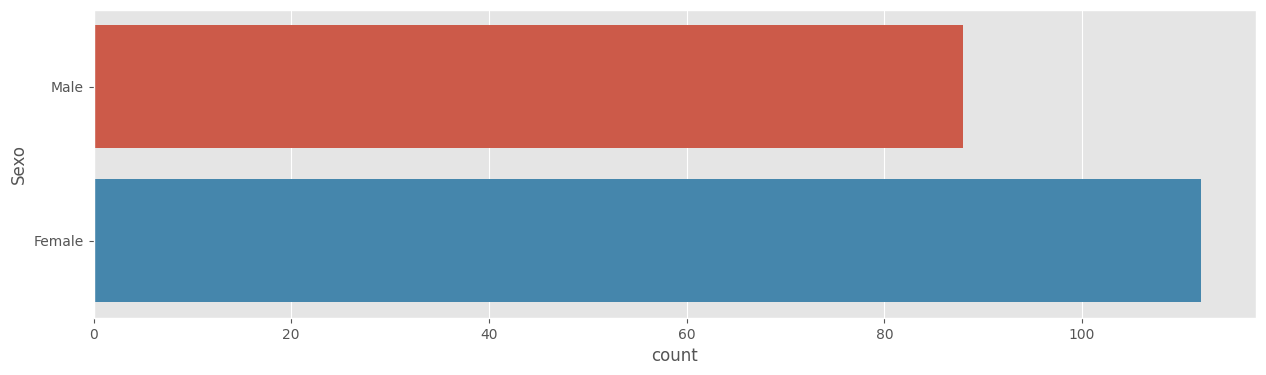

In [ ]:
plt.style.use('ggplot')
plt.figure(1 , figsize = (15 , 4))
sns.countplot(y = 'Sexo' , data = df)
plt.show()

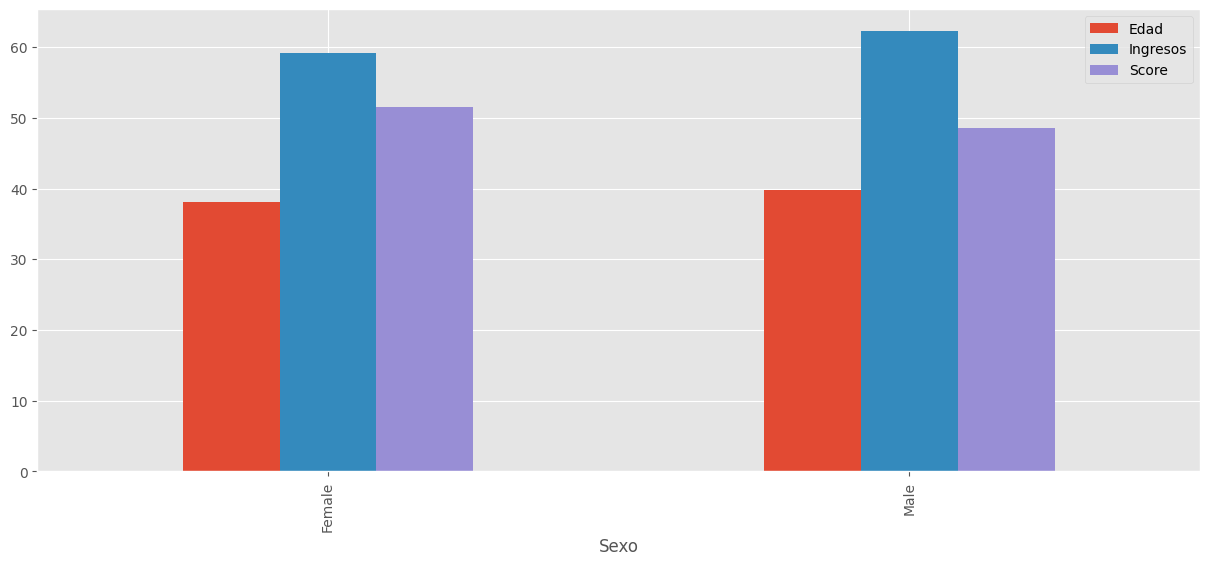

In [ ]:
df.groupby('Sexo').mean().plot(kind='bar',figsize=(15,6));

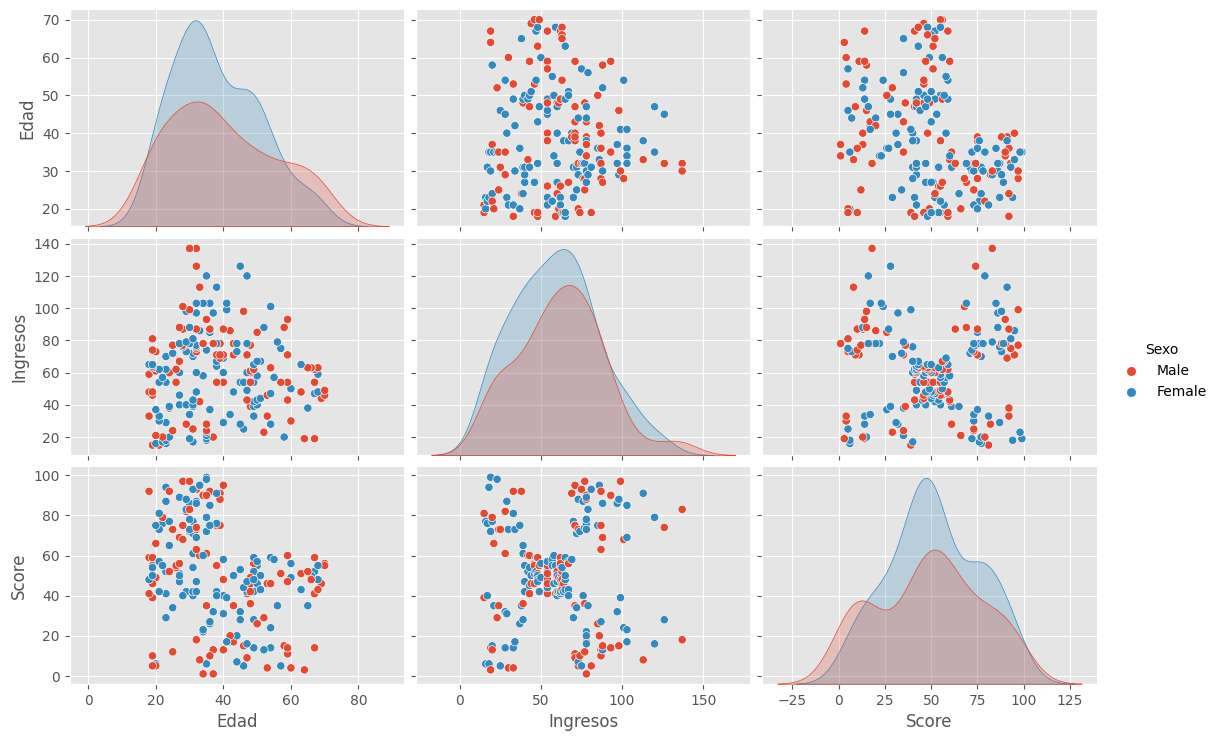

In [ ]:
sns.pairplot(df, hue='Sexo', aspect=1.5)
plt.show()

De este gráfico vemos que la variable de Sexo no tiene una relación directa con la segmentación de los clientes. Pero podemos ver algunas agrupaciones incipientes en la relación Ingresos vs Score de consumo.

También vemos que no tenemos outliers.

# 2. Segmentación con k-Means

## Preparación

Ahora vamos a modificar el dataset para mantener únicamente las variables numéricas.

In [ ]:
df_kmeans = df.select_dtypes(include = 'number').copy()
df_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Edad      200 non-null    int64
 1   Ingresos  200 non-null    int64
 2   Score     200 non-null    int64
dtypes: int64(3)
memory usage: 4.8 KB


In [ ]:
df_kmeans.head()

,Edad,Ingresos,Score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


## Elegir número de clusters

Seleccionamos el número de clústeres, k, y para ello vamos a realizar varias veces los cálculos usando valores de k con un rango de 2 a 10.
- **n_init**= Número de repeticiones a realizar, en este caso 10.
- **n_clusters**= Número de clusters a agrupar, en este caso probamos con clusters de 2 a 10.

De la salida del modelo obtendremos:
- **labels_**: Etiqueta del segmento identificado para cada registro.
- **inertia_**: Suma de las distancias al cuadrado de las muestras a su centroide más cercano.
- **cluster_centers_**: Los centroides de cada cluster.

In [ ]:
# Test with a range of 2-10 clusters
num_clusters = list(range(2,11))

# Metrics results
elbow_metric = []
silhouette_metric = []
calinski_metric = []

# Test iterations
for num_cluster in num_clusters:
  # Instantiate the model
  km = KMeans(random_state=1234, n_clusters=num_cluster, n_init=10)
  # Train the model
  km.fit(df_kmeans)

  # Collect the metrics
  elbow_metric.append(km.inertia_)
  silhouette_metric.append(silhouette_score(df_kmeans, km.labels_))
  calinski_metric.append(calinski_harabasz_score(df_kmeans, km.labels_))

metrics = pd.DataFrame({'Iteration': num_clusters,
              'Elbow': elbow_metric,
              'Silhouette': silhouette_metric,
              'Calinski': calinski_metric}).set_index('Iteration')

metrics

,Elbow,Silhouette,Calinski
Iteration,,,
2,212840.169821,0.293166,89.280970
3,143342.751572,0.383935,113.705071
4,104366.151456,0.405463,127.983829
5,75350.779172,0.444286,151.043860
6,58300.443322,0.452344,166.720493
7,51118.839039,0.439751,162.154604
8,44342.317393,0.426275,163.591968
9,40939.900555,0.394841,156.215939
10,37558.732122,0.375239,152.467190


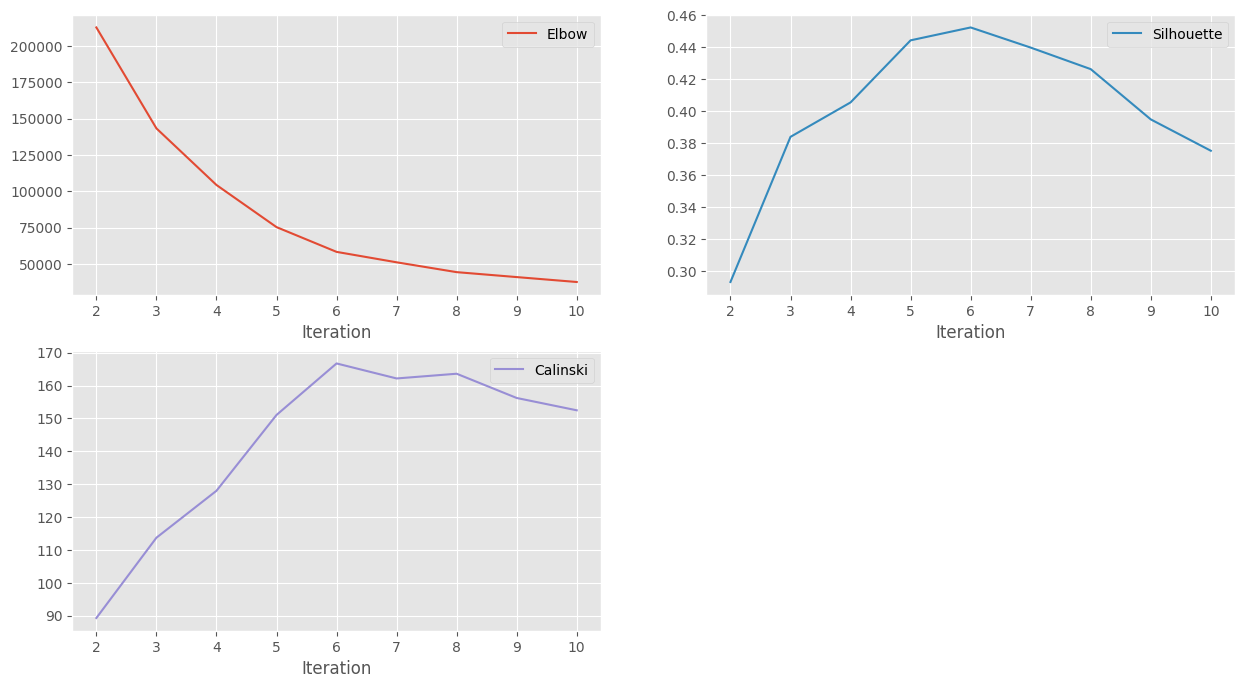

In [ ]:
metrics.plot(subplots = True, figsize = (15,8), layout = (2,2), sharex = False);

*   **Elbow:** El método Elbow nos dice que debemos seleccionar el cluster donde hay un cambio significativo en inercia. De acuerdo al gráfico, el valor adecuado de clusters sería de 3 ó 5.
*  **Silhouette**: El gráfico de Silhouette nos dice que el score Silhouette se maximiza en 6 clusters.
*  **Calinski**: El gráfico de Calinski nos dice que el índice Calinski-Harabasz se maximiza en 6 clusters.


## Modelamiento

Vemos los resultados con 3 clusters:

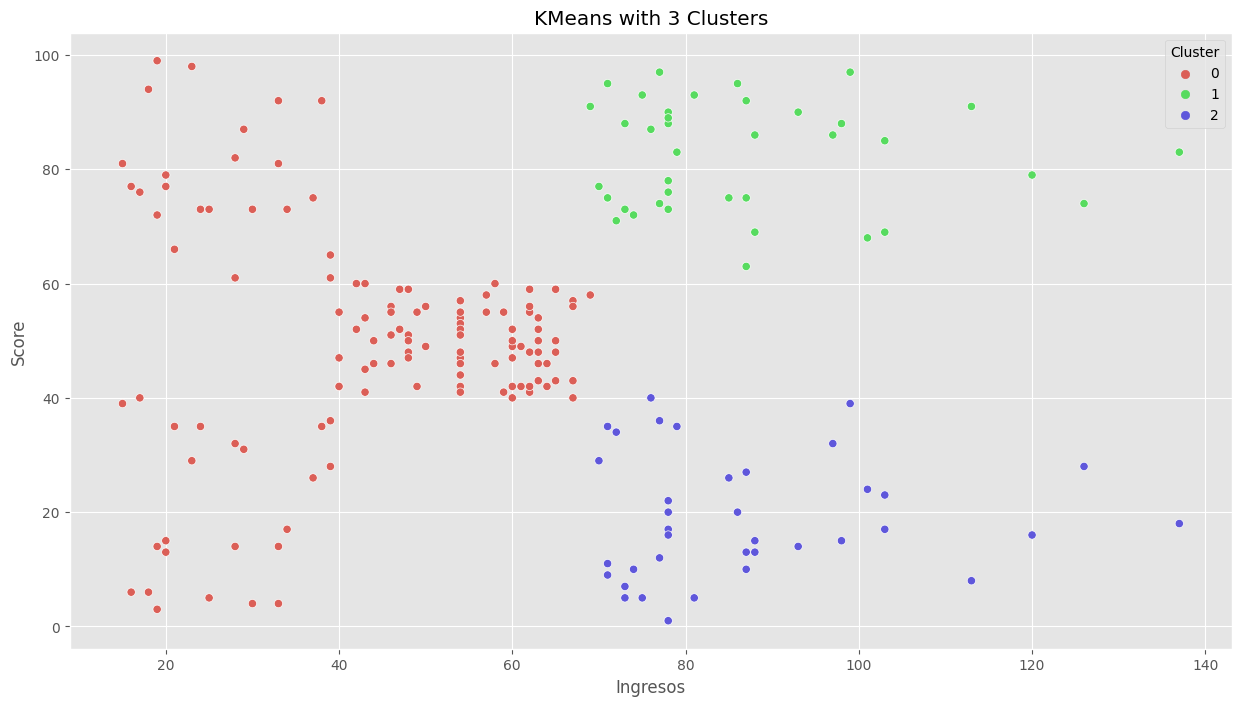

In [ ]:
# 3 cluster
km3 = KMeans(random_state=1234, n_clusters=3, n_init=10)
km3.fit(df_kmeans)

df_kmeans['Cluster'] = km3.predict(df_kmeans)

plt.figure(figsize=(15, 8))
sns.scatterplot(data=df_kmeans, x='Ingresos', y='Score', hue='Cluster',
                palette=sns.color_palette('hls', 3))
plt.title('KMeans with 3 Clusters')
plt.show()

Ahora vemos los resultados con 5 clusters y sus centroides:

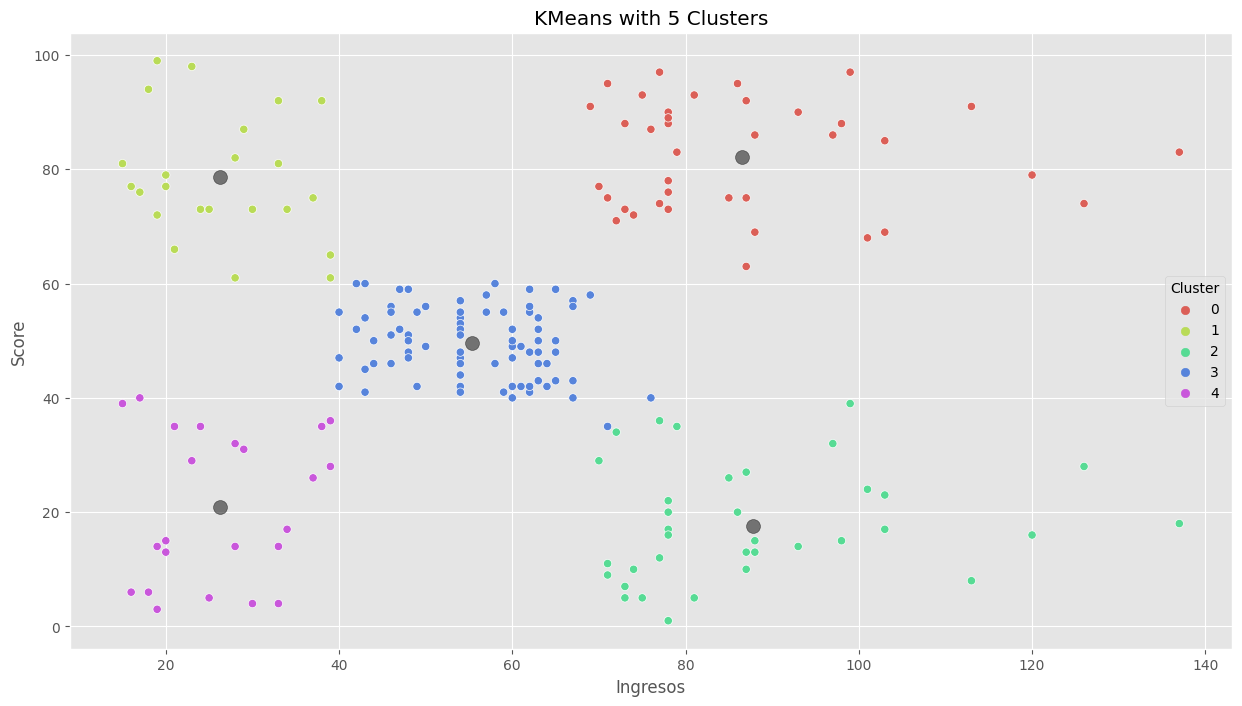

In [ ]:
# 5 cluster
km5 = KMeans(random_state=1234, n_clusters=5, n_init=10)
km5.fit(df_kmeans)

df_kmeans['Cluster'] = km5.predict(df_kmeans)
centroids = km5.cluster_centers_

plt.figure(figsize=(15, 8))
sns.scatterplot(data=df_kmeans, x='Ingresos', y='Score', hue='Cluster',
                palette=sns.color_palette('hls', 5))
plt.scatter(x=centroids[:,1], y=centroids[:,2], s=100, c='black', alpha=0.5)
plt.title('KMeans with 5 Clusters')
plt.show()

5 clusters parecen más adecuados que 3, de acuerdo a la forma en que se dispersan los datos.

Sobre los 5 clusters resultado podemos decir:
1. **Cluster 0:** Altos ingresos, alto score de consumo.
2. **Cluster 1:** Bajos ingresos, alto score de consumo.
3. **Cluster 2:** Altos ingresos, bajo score de consumo.
4. **Cluster 3:** Moderados, similares ingresos y score de consumo.
5. **Cluster 4:** Bajos ingresos, bajo score de consumo.



Podemos ver cómo se agrupan y se perfilan los clientes en cada cluster k-Means, utilizamos la variable género para ver cómo se distribuyen dentro de cada cluster:

In [ ]:
df_final = df_kmeans
df_final['Sexo'] = df['Sexo']
df_final.groupby(['Cluster','Sexo']).agg({"Edad":["count","mean"],
  'Ingresos':'mean',
  'Score':'mean'})

Edad              Ingresos      Score
               count       mean       mean       mean
Cluster Sexo                                         
0       Female    21  32.190476  86.047619  81.666667
        Male      18  33.277778  87.111111  82.666667
1       Female    14  25.857143  26.642857  79.142857
        Male       9  25.000000  25.777778  77.666667
2       Female    17  42.176471  89.823529  22.764706
        Male      19  39.315789  85.894737  12.947368
3       Female    46  41.456522  55.347826  49.065217
        Male      33  45.363636  55.212121  50.272727
4       Female    14  43.214286  27.357143  21.714286
        Male       9  48.333333  24.666667  19.666667

Podemos ver que las asignaciones por cluster están bien distribuidas, teniendo un cluster central con la mayor concentración.

In [ ]:
df_kmeans["Cluster"].value_counts()

3    79
0    39
2    36
4    23
1    23
Name: Cluster, dtype: int64

También podemos ver el significado de cada cluster más claramente con un swarmplot.

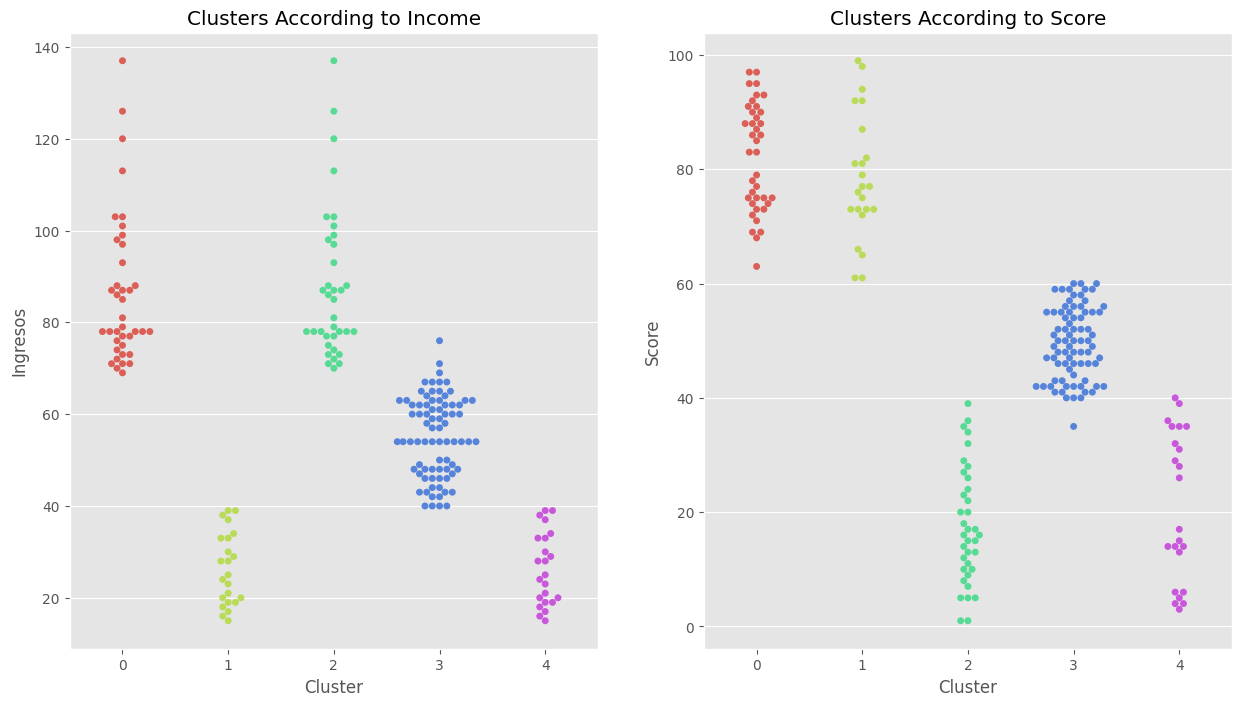

In [ ]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(121)
sns.swarmplot(data=df_kmeans, x='Cluster', y='Ingresos', ax=ax,
              palette=sns.color_palette('hls', 5))
ax.set_title('Clusters According to Income')

ax = fig.add_subplot(122)
sns.swarmplot(data=df_kmeans, x='Cluster', y='Score', ax=ax,
              palette=sns.color_palette('hls', 5))
ax.set_title('Clusters According to Score')

plt.show()

Por último vemos la relación entre Edad vs Ingresos y vs Score de Consumo.

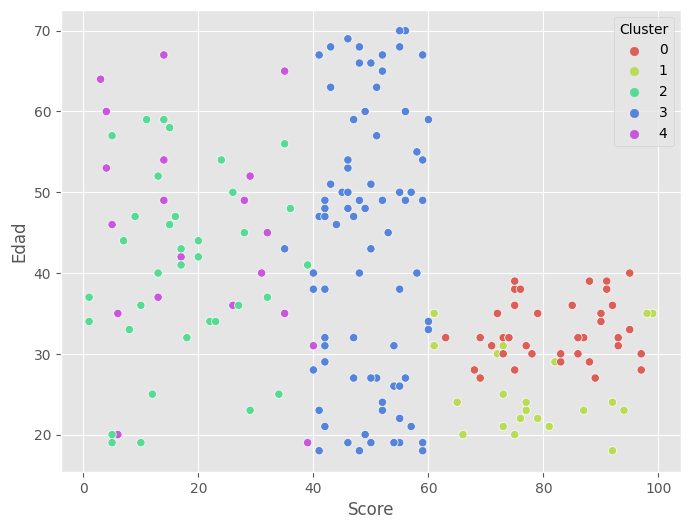

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_kmeans['Score'],
  y=df_kmeans['Edad'],
  hue=df_kmeans['Cluster'],
  palette=sns.color_palette('hls', 5));

Los score de consumo más altos los tienen las personas menores a 40 años.

En el cluster 3 promedio (ingresos y score moderados) se encuentran personas de todas las edades.

Las personas en el cluster 2 (altos ingresos, bajo score de consumo), están más concentradas entre los mayores que 30 años, que entre los más jóvenes.

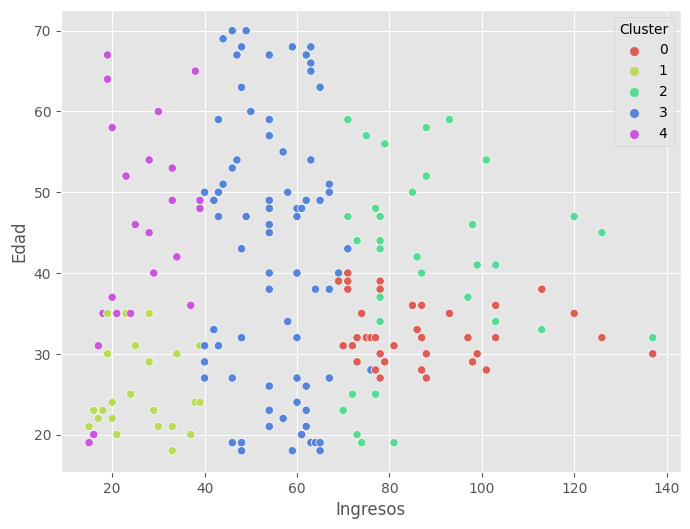

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_kmeans['Ingresos'],
  y=df_kmeans['Edad'],
  hue=df_kmeans['Cluster'],
  palette=sns.color_palette('hls', 5));

Podemos ver que las personas con más ingresos (clusters 0 y 2) están en general por encima de los 30 años.


# 3. Segmentación con DBSCAN

## Preparación

Antes vamos a escalar las variables númericas.

In [ ]:
df_dbscan = df.select_dtypes(include = 'number').copy()
df_dbscan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Edad      200 non-null    int64
 1   Ingresos  200 non-null    int64
 2   Score     200 non-null    int64
dtypes: int64(3)
memory usage: 4.8 KB


In [ ]:
scl = StandardScaler()

df_dbscan = scl.fit_transform(df_dbscan)
df_dbscan = pd.DataFrame(df_dbscan, columns=['Edad','Ingresos','Score'])
df_dbscan.head()

,Edad,Ingresos,Score
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


In [ ]:
df_dbscan.describe()

,Edad,Ingresos,Score
count,2.000000e+02,2.000000e+02,2.000000e+02
mean,-1.021405e-16,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,7.284319e-01,6.656748e-01,8.851316e-01
max,2.235532e+00,2.917671e+00,1.894492e+00


## Elegir epsilon

Para la ejecución de **DBSCAN** utilizaremos los siguientes parámetros:

- Para el **min_samples** el mínimo recomendado ya que el dataset tiene un **número de observaciones pequeño** (**min_samples=3**)
- Para el valor de epsilon vamos a calcular las distancias para este valor de 3.

Para ello utilizamos el algoritmo **knn** (K vecinos) con k=3, representaremos la distancia y el valor que doble la curva será el valor de densidad elegido.

0.2851517131304658


Text(0, 0.5, 'Distance')

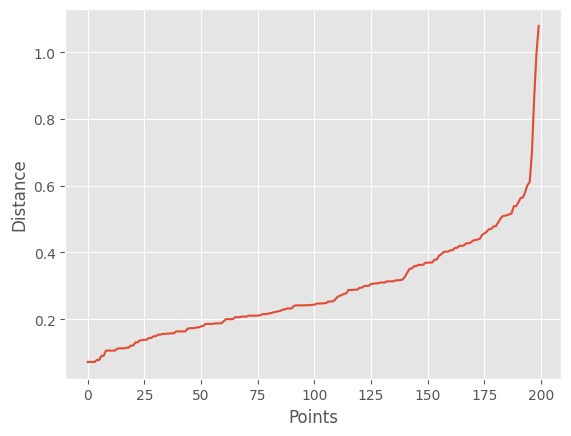

In [ ]:
k=3

# Calculate knn (k neighbors)
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(df_dbscan)
distances, indexes = neighbors.kneighbors(df_dbscan)
distances = np.sort(distances, axis=0)

# Distances
distances = distances[:,1]
print(distances.mean())
i = np.arange(len(distances))

sns.lineplot(
  x = i,
  y = distances
)

plt.xlabel("Points")
plt.ylabel("Distance")

Vemos que el valor de epsilón óptimo está en torno a 0.6.

Por lo tanto utilizaremos min_samples=3 y eps=0.6

## Modelamiento

In [ ]:
dbscan = DBSCAN(eps=0.6, min_samples=3).fit(df_dbscan)
labels = dbscan.labels_
df_dbscan['DBSCAN'] = labels
df_dbscan.head()

,Edad,Ingresos,Score,DBSCAN
0,-1.424569,-1.738999,-0.434801,-1
1,-1.281035,-1.738999,1.195704,0
2,-1.352802,-1.700830,-1.715913,-1
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0


Tenemos 4 clusters resultantes, donde el primero es un gran cluster que se lleva la mayoría de los datos, el segundo tiene algo de concentración, y los 2 restantes tienen pocos datos.

Y tenemos 14 outliers en el cluster -1.

In [ ]:
df_dbscan["DBSCAN"].value_counts()

 0    143
 1     39
-1     14
 2      4
Name: DBSCAN, dtype: int64

Visualizamos Ingresos vs Score de Consumo con los clusters asignados con DBSCAN.

number of noise(s):  14


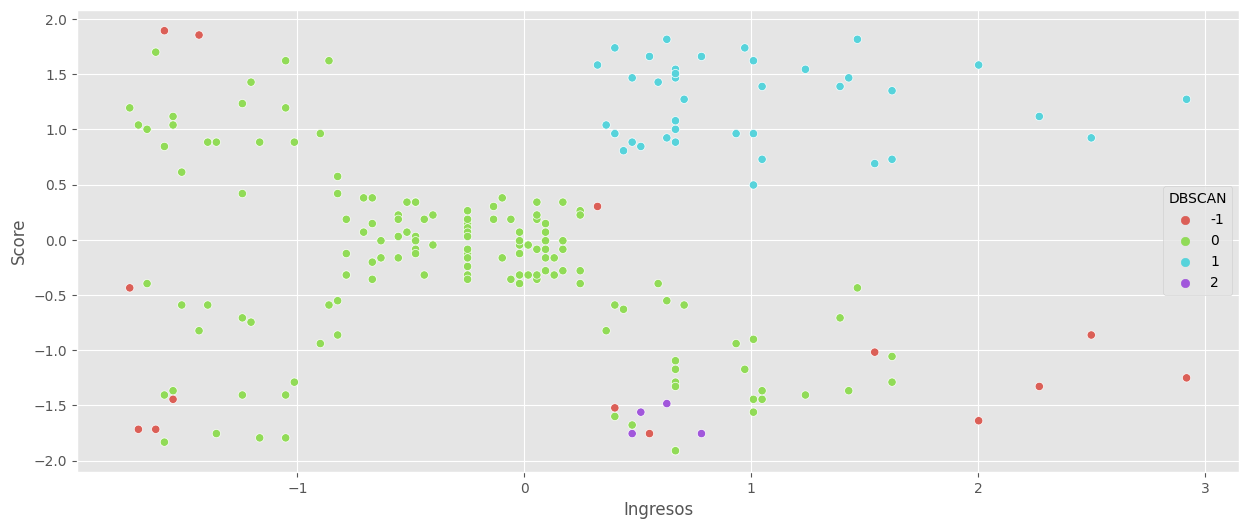

In [ ]:
plt.figure(figsize=(15,6))
sns.scatterplot(x=df_dbscan['Ingresos'],
  y=df_dbscan['Score'],
  hue=df_dbscan['DBSCAN'],
  palette=sns.color_palette('hls', 4))

n_noise_ = list(labels).count(-1)
print('number of noise(s): ', n_noise_)

Como podemos ver DBSCAN no se desempeña tan bien en la segmentación del dataset, dado que la densidad de los datos no es tan fuerte.

Ahora visualizamos Score vs Edad con los clusters asignados con DBSCAN.

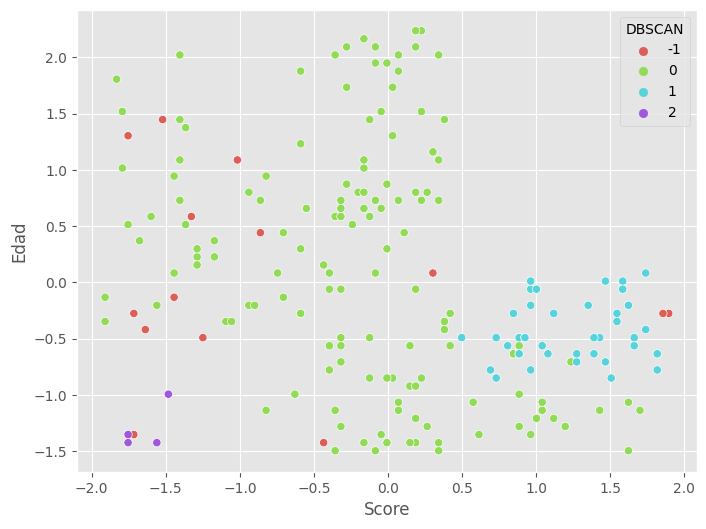

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_dbscan['Score'],
  y=df_dbscan['Edad'],
  hue=df_dbscan['DBSCAN'],
  palette=sns.color_palette('hls', 4));

Por último podemos ver cómo se agrupan y se perfilan los clientes en cada cluster DBSCAM.

Utilizamos la variable Sexo para ver cómo se distribuyen dentro de cada cluster:

In [ ]:
df_final = df_dbscan
df_final['Sexo'] = df['Sexo']
df_final.groupby(['DBSCAN','Sexo']).agg({"Edad":["count","mean"],
  'Ingresos':'mean',
  'Score':'mean'})

Edad            Ingresos     Score
              count      mean      mean      mean
DBSCAN Sexo                                      
-1     Female     9  0.146324  0.093133 -0.482250
       Male       5 -0.204535  0.406123 -1.257819
 0     Female    82  0.032645 -0.327661 -0.189563
       Male      61  0.319009 -0.279801 -0.255968
 1     Female    21 -0.477932  0.972848  1.221585
       Male      18 -0.399900  1.013441  1.260407
 2     Male       4 -1.298977  0.598878 -1.638270

# 4. Conclusiones

Con la aplicación de los 2 algoritmos podemos concluir:
1.   Con k-Means obtuvimos 5 clusters bastante consistentes, que agrupan a los clientes de acuerdo a sus Ingresos y Score de Consumo.
2.   Con DBSCAN obtuvimos 3 clusters no tan bien definidos, dado que la densidad de los datos no es tan fuerte, y 14 outliers.
3.   Con k-Means los 5 clusters resultado están bien distribuidos, teniendo un cluster central con la mayor concentración.
4.   Con DBSCAN los 3 clusters resultado están muy concentrados en 1 cluster grande, otro con algunos pocos valores, y un tercero con muy pocos.
5.   k-Means en general se desempeñó mejor que DBSCAN para encontrar clusters más definidos, y más consistentes respecto a los datos numéricos más representativos del dataset, Ingresos vs Score de Consumo.

